# Práctica 2: Vecinos próximos y k-means
## Autores: Alejandro Benimeli Miranda y Rodrigo Juez Hernández

**NOTA:** Para la correcta ejecución de este notebook se necesita la librería PIL para generar las visualizaciones de los clústers. Si no se tiene, el notebook nofuncionará. 
Si no la tiene instalada, ejecute la celda siguiente (O instalela de la forma que prefiera). Si sigue dando error, por favor contáctenos.

In [1]:
!pip install Pillow

You are using pip version 18.1, however version 21.3.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
import sklearn.cluster
import numpy as np
import pandas as pd
import re

from PIL import Image
from math import ceil
import os
from matplotlib import pyplot as plt

#our implementation
from Datos import Datos
import EstrategiaParticionado
import ClasificadorKNN
import ClusteringKMeans as KMeans


str_mean = "{:.4f} ± {:.4f}"
regexrule_filename = "../.*?/(.*?).data"
tag_propia = "Propia"
tag_sklearn = "Sklearn"

# Ejecución Código

### KNN

In [3]:
def compare_implementation_cross(n, cv, dataset_filename, normalizado):
    dataset = Datos(dataset_filename)
    
    data_sklearn = dataset.datos
    if normalizado == True:
        data_sklearn = dataset.normalizarDatos(dataset.datos, dataset.nominalAtributos)
    
    X = data_sklearn.loc[:, dataset.datos.columns != "Class"].to_numpy()
    y = data_sklearn["Class"].to_numpy()
    

    clasificador = KNeighborsClassifier(n_neighbors=n)
    precisiones = cross_val_score(clasificador, X, y, cv=cv)
    skmean = 1 - np.mean(precisiones)
    skstd = np.std(precisiones)


    #comparacion de knn
    estrategia=EstrategiaParticionado.ValidacionCruzada(cv)
    clasificador=ClasificadorKNN.ClasificadorKNN(n, normalize = normalizado)
    mean, std = clasificador.validacion(estrategia,dataset,clasificador)

    return (skmean, skstd), (mean, std)

def implementation_dict(nks, cv, filename, normalizado):
    table = {tag_propia: {}, tag_sklearn:{}}
    for k in nks:
        (skmean, skstd), (mean, std) = compare_implementation_cross(n = k, cv = cv, dataset_filename = filename, normalizado = normalizado)
        table[tag_propia][k] = str_mean.format(mean, std)
        table[tag_sklearn][k] = str_mean.format(skmean, skstd)

    return table


def implementation_two_datasets(nks,cv, filename1, filename2, normalizado = False):
    tag1, tag2 = re.findall(regexrule_filename, filename1)[0], re.findall(regexrule_filename, filename2)[0]
    
    #def implementation_two_datasets(nks, cv, filename1, filename2):
    wdbc_dict = implementation_dict(nks = nks,cv = cv, filename = filename1, normalizado = normalizado)
    indian_dict = implementation_dict(nks = nks,cv = cv, filename = filename2, normalizado = normalizado)
    
    


    y = nks
    x = [(tag1, tag_propia),
         (tag1, tag_sklearn),
         (tag2, tag_propia),
         (tag2, tag_sklearn)]
    names = ["dataset", "implementación"]
    dicts = {tag1: wdbc_dict, tag2: indian_dict}
    
    
    tabla_final = pd.DataFrame(index=y, columns=pd.MultiIndex.from_tuples(x, names = names), dtype=float)
    for tag in [tag1, tag2]:
        for k in nks:
            tabla_final.loc[k, (tag, tag_propia)] = dicts[tag][tag_propia][k]
            tabla_final.loc[k, (tag, tag_sklearn)] = dicts[tag][tag_sklearn][k]

    return tabla_final

### KMeans

#### KMeans visualizacion clustering

In [4]:
def crear_imagen_clusters(dir_fotos, clusters_digitos, foto_dim_x=50, foto_dim_y=80, max_per_line=24, margen_y=20):

    dim_x = max_per_line * foto_dim_x
    dim_y = -margen_y
    for cluster in clusters_digitos:
        dim_y += ceil(len(cluster)/max_per_line) * foto_dim_y + margen_y

    img = Image.new("RGB", (dim_x, dim_y), (47,79,79))

    curr_y = 0
    for cluster in clusters_digitos:
        curr_x = 0
        counter_linea = 0
        for digito in cluster:

            if counter_linea == max_per_line:
                curr_x = 0
                curr_y += foto_dim_y
                counter_linea = 0

            digit_img = Image.open(os.path.join(dir_fotos, "i{:05d}.png".format(digito + 1)))
            img.paste(digit_img, (curr_x, curr_y))
            
            counter_linea += 1
            curr_x += foto_dim_x

        curr_y += foto_dim_y + margen_y

    return img


def show_visualization(clusters1, clusters2, title1, title2, folder_base = "../fotos_digitos/", zoom = 2):
    img1 = crear_imagen_clusters(folder_base, clusters1)
    img2 = crear_imagen_clusters(folder_base, clusters2)
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(img1)
    axs[0].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
    axs[0].title.set_text(title1)
    
    
    axs[1].imshow(img2)
    axs[1].tick_params(left = False, right = False , labelleft = False, labelbottom = False, bottom = False)
    axs[1].title.set_text(title2)
    plt.title("Comparación Clusters")
    plt.tight_layout()
    
    w, h = fig.get_size_inches()
    fig.set_size_inches(w * zoom, h * zoom)
    
    
    plt.show()
    
    
    

In [5]:
def comparacion_kmeans(n_clusters, filename):
    dataset=Datos(filename)
    X = dataset.datos.loc[:, dataset.datos.columns != "Class"].to_numpy()
    y = dataset.datos["Class"].to_numpy()

    labels = sklearn.cluster.KMeans(n_clusters=n_clusters).fit(X, y).labels_
    skclusters =  [[idx for idx, j in enumerate(labels) if j == i] for i in range(n_clusters)]
    confusionsklearn = KMeans.KMeans.matriz_confusion(dataset, skclusters )

    kmeans = KMeans.KMeans(dataset, n_clusters)
    kmeans.clusterea()
    confusionimplementacion = kmeans.matriz_confusion(dataset, kmeans.clusters)
    
    
    df = pd.concat([confusionimplementacion, confusionsklearn],keys= ["Propia", "Sklearn"],axis=1)
    
    
    def highlight_max(s, props=''):
        return np.where(s == np.nanmax(s.values), props, '')

    idx = pd.IndexSlice
    slice_ = idx[idx[:,('Propia')]]
    slice2_ = idx[idx[:,('Sklearn')]]
    
    show_visualization(kmeans.clusters, skclusters, title1 = "Clusters Propios", title2 = "Clusters Sklearn")

    
    
    return df.style.apply(highlight_max, props='color:black;', axis=0, subset=slice_).set_properties(**{'background-color': '#ffffb3'}, subset=slice_).apply(highlight_max, props='color:black;', axis=0, subset=slice_).set_properties(**{'background-color': '#66FFFF'}, subset=slice2_)

# Memoria
**¡ATENCIÓN!** Las celdas del KNN tardan muchos minutos en ejecutarse, lo preferible es que se usen los resultados ya puestos en la memoria, pero si decide ejecutarlo de nuevo tenga en cuenta que tarda bastante tiempo.

### Comparación KNN Sklearn vs. Implementación Propia

Los argumentos más importantes de KNN en sklearn, a parte de la 'k', son “metric” and “p”, que por defecto son “minkowski” y 2 respectivamente, que justo significan la distancia euclídea.
Como puedes ver en la siguiente formula de minkowski, con p=2 tenemos la formula de la distancia euclídea.
![Image of Minkowski](https://i.stack.imgur.com/U6qGk.png)

#### Sin Normalizar

In [6]:
nks = [ i for i in range(5, 18, 2)]
implementation_two_datasets(nks = nks, cv = 5, filename1 = '../ConjuntosDatosP2Knn/wdbc.data', filename2 = '../ConjuntosDatosP2Knn/pima-indians-diabetes.data', normalizado = False)

dataset                    wdbc                  pima-indians-diabetes  \
implementación           Propia          Sklearn                Propia   
5               0.0633 ± 0.0238  0.0721 ± 0.0218       0.2682 ± 0.0200   
7               0.0668 ± 0.0275  0.0738 ± 0.0264       0.2748 ± 0.0213   
9               0.0598 ± 0.0227  0.0685 ± 0.0279       0.2735 ± 0.0344   
11              0.0615 ± 0.0148  0.0703 ± 0.0277       0.2643 ± 0.0124   
13              0.0650 ± 0.0162  0.0668 ± 0.0286       0.2656 ± 0.0240   
15              0.0704 ± 0.0188  0.0703 ± 0.0313       0.2487 ± 0.0434   
17              0.0702 ± 0.0328  0.0703 ± 0.0323       0.2644 ± 0.0259   

dataset                          
implementación          Sklearn  
5               0.2760 ± 0.0202  
7               0.2643 ± 0.0176  
9               0.2578 ± 0.0254  
11              0.2513 ± 0.0321  
13              0.2447 ± 0.0396  
15              0.2616 ± 0.0438  
17              0.2486 ± 0.0461

Los errores de tanto nuestra implementación como la de SKlearn son muy similares para un mismo valor de K en ambos datasets, lo que nos hace creer que nuestra implementación esta bien. En cuanto a las desviaciones son bastante similares, aunque en algunos casos de la SKlearn supera a la nuestra. De todas formas, en los casos donde la supera la diferencia es prácticamente despreciable (<0.02).

Para nuestra implementación y el dataset *wdbc*, el valor óptimo de la K es el 9, ya que es el valor que da un error más bajo. En el caso del dataset *prima-indians*, el mejor valor de K es 15.
En el caso de SKlearn, para *wdbc*, el mejor valor de K es 13. Y para *prima-indians*, es 13 también.

##### Normalizado

Al normalizar los datos obtenemos mejores resultados. Esto tiene sentido, ya que los datos del dataset pueden no estar en la misma escala, y al calcular la distancia euclídea, algunos atributos pueden afectar más que otros. Por lo tanto, al normalizar esperamos mejores resultados.

In [7]:
nks = [ i for i in range(5, 18, 2)]
implementation_two_datasets(nks = nks, cv = 5, filename1 = '../ConjuntosDatosP2Knn/wdbc.data', filename2 = '../ConjuntosDatosP2Knn/pima-indians-diabetes.data', normalizado = True)

dataset                    wdbc                  pima-indians-diabetes  \
implementación           Propia          Sklearn                Propia   
5               0.0299 ± 0.0089  0.0351 ± 0.0096       0.2656 ± 0.0270   
7               0.0369 ± 0.0116  0.0316 ± 0.0090       0.2628 ± 0.0727   
9               0.0351 ± 0.0215  0.0316 ± 0.0162       0.2630 ± 0.0492   
11              0.0299 ± 0.0105  0.0369 ± 0.0203       0.2630 ± 0.0322   
13              0.0352 ± 0.0148  0.0351 ± 0.0166       0.2526 ± 0.0278   
15              0.0440 ± 0.0125  0.0386 ± 0.0131       0.2436 ± 0.0323   
17              0.0386 ± 0.0197  0.0422 ± 0.0151       0.2513 ± 0.0208   

dataset                          
implementación          Sklearn  
5               0.2669 ± 0.0201  
7               0.2578 ± 0.0244  
9               0.2643 ± 0.0252  
11              0.2552 ± 0.0168  
13              0.2422 ± 0.0108  
15              0.2382 ± 0.0190  
17              0.2330 ± 0.0239

Cabe destacar que para el dataset *wdbc*, el error prácticamente se reduce a la mitad. Vemos también que ahora los errores de SKlearn son un poco mas pequeños que los de nuestra implementación, aunque la diferencia es tan pequeña que probablemente sea despreciable.

Para nuestra implementación y el dataset *wdbc*, el valor óptimo de la K es el 11. En el caso del dataset *prima-indians*, el mejor valor de K es 15.
En el caso de SKlearn, para *wdbc*, el mejor valor de K es 7 (El 9 tiene el mismo error pero más desviación). Y para *prima-indians*, es 17.

### Comparación KMeans Sklearn vs. Implementación Propia

Los argumentos más importantes de KMeans en Sklearn son:
- “init” por defecto es “k-means++”, lo cual significa que los centroides iniciales no son completamente aleatorios (para eso hay que poner “random”, si no unos más optimizados para que el clustering corra más rápido, lo hemos dejado por defecto con la opimización.
- “max_iter” es el número máximo de iteraciones para el clustering, en nuestra implementación no tenemos un número máximo, es hasta que no varía, sin embargo vimos que normalmente como mucho eran 30 iteraciones, por lo que el valor default de la función (300) está bien y así lo hemos dejado.
- “tol” es la tolerancia para parar la ejecución, es decir nosotros paramos cuando los centroides son iguales\* sklearn permite una cierta tolerancia.

\* Realmente paramos cuando los clusters no cambian durante 2 iteraciones, aunque esto significa que en la ultima iteración los centroides no cambian

Se han necesitado 25 iteraciones para formar los clusters.


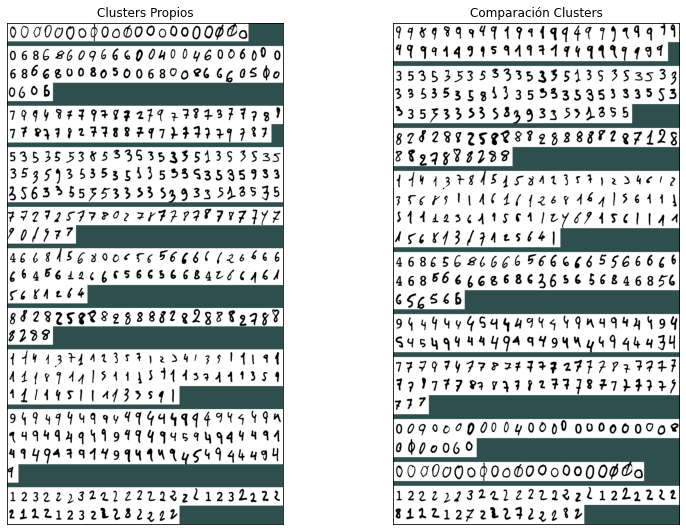

In [8]:
comparacion_kmeans(10, '../ConjuntosDatosP2KMeans/nums.csv')

Para poder visualizar mejor cómo se comporta el algoritmo, hemos creado una función que muestra una imágen con los dígitos que se han agrupado juntos. También devolvemos las matrices de confusión. En estas, se ha añadido un \_X a cada cluster indicando cuál es el dígito que más aparece en dicho clúster. E.g. c2_4 es el clúster 2 y el dígito que más aparece es el 4.

Ajustando el número de clústers a 10, queremos ver si el algoritmo es capaz de agrupar todas las imágenes de un mismo dígito.

##### Comparación:

Observamos que en ambos casos se han creado dos clústers para el 0. En estos clusters, aunque hay ua mayoría de 0s, a veces se confunden con 8s o 6s.

El algoritmo ha sido capaz de agrupar una gran cantidad de 1s en ambos casos, aunque en los dos también los ha confundido con unos cuantos 2s, 5s, 6s, 7s y 8s. Al ver las fotos generadas, se puede apreciar que los dígitos en los que se ha confundido son algo estirados, como el 1, por lo que es entendible la confusión.

Nuestro algoritmo agrupa muy bien los 2s, aunque a veces con algunos 7s, mientras que SKlearn ha sido capaz de crear un clúster con prácticamente solo 2s. La forma de los 2s y 7s es similar, por lo que entendemos que los agrupe, pero sorprende como SKlearn si que los puede diferenciar mejor.

En ambas implementaciones se confunden los 3s con los 5s, aunque SKlearn a veces también los confunde con 8s.

Nosotros hemos conseguido agrupar casi todos los 4s, aunque confunde algunos 9s con esos 4s. SKlearn confunde mucho los 4s y los 9s, habiendo un clúster que tiene casi todos los 4s y 9s.

Ambas implementaciones agrupan bien los 6s, con pocos errores.

SKlearn agrupa muy bien los 7s, mientras que nosotros los confundimos con los 1s y 2s como ya hemos mencionado.

Ambas agrupan los 8s relativamente bien, aunque también hay bastantes 8s en clústers con otros dígitos.

Sklearn es capaz de agrupar muy bien los 9s.

##### Conclusión
En general ambas implementaciones dan unos resultados bastante similares, aunque algunos dígitos se agrupan mejor dependiendo de cual se use. Posiblemente esto se deba a los centroides aleatorios y cambiaría si se volviese a ejecutar.

Mirando las fotografías de qué clústers se han generado estamos bastante satisfechos con nuestros resultados, ya que aunque confunde algunos dígitos, podemos ver que en la mayoría de los casos se debe a cómo algunos de ellos estaban escritos.

#### Cómo afecta el número de clústers

Hemos probado números de clusters de 11 a 20 para ver si así se agrupan mejor los dígitos, ya que es posible que haya más de una forma de escribir algún dígito, por lo que podría ser interesante que haya un clúster por cada forma de escribirlo.

Hemos observado que a medida que el número de clústers aumenta, se reduce ligeramente el número de dígitos que se confunden con otros, aunque sigue pasando hasta con 20. También observamos que para un número de clústers cercano a 20, aparecen clústers con muy pocos dígitos, incluso alguno con solo 1.

En general hemos visto que 15 clústers da el mejor resultado: Los clústers estan medianamente balanceados (no hay ninguno con muchísimos ni con pocos dígitos) y se confunden menos dígitos que con valores menores a 15.

Se han necesitado 18 iteraciones para formar los clusters.


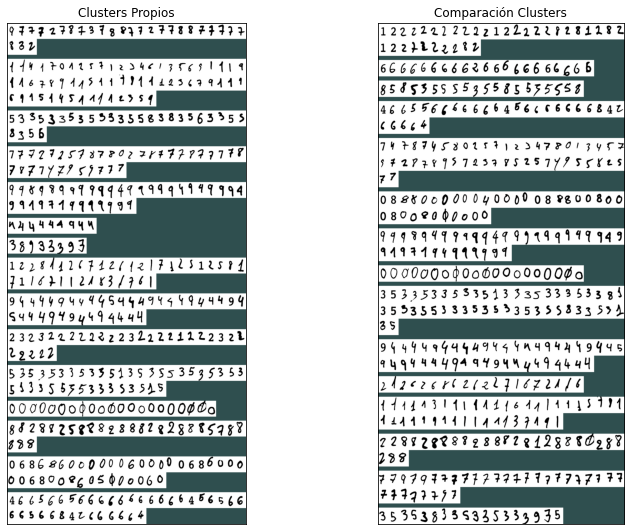

In [9]:
comparacion_kmeans(15, '../ConjuntosDatosP2KMeans/nums.csv')